# 01 — EDA: Raw Data Inspection

**Goal:** Validate that all 41 FOMC meetings load cleanly, inspect the canonical intraday bar format, check data coverage across sources, and surface any quality issues before building the pipeline.

**Sections:**
1. Setup
2. FOMC metadata
3. Policy rates
4. Intraday bars — structure & coverage
5. Sample bars around the announcement window
6. Coverage heatmap
7. Transcript availability

## 1. Setup

In [1]:
import sys
import pathlib

# Add project root to path so we can import from src/
PROJECT_ROOT = pathlib.Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

DATA_RAW = PROJECT_ROOT / "data-raw"
DATA_CLEAN = PROJECT_ROOT / "data-clean"
DATA_CLEAN.mkdir(exist_ok=True)

print(f"Project root : {PROJECT_ROOT}")
print(f"Data raw     : {DATA_RAW}")

Project root : /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project
Data raw     : /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-raw


In [2]:
import logging
import warnings

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns

from src.config import load_config
from src.ingest import (
    load_fomc_metadata,
    load_intraday_bars,
    load_policy_rates,
    load_transcripts,
    save_transcripts_json,
)
from src.clean import coverage_report, qa_intraday_bars, write_parquet

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
warnings.filterwarnings("ignore", category=FutureWarning)

cfg = load_config(PROJECT_ROOT / "configs" / "config.yaml")
print("Config loaded. Pairs:", cfg.pairs)
print("Windows:", cfg.windows.statement, cfg.windows.digestion)

Config loaded. Pairs: ['USDEUR', 'USDJPY', 'USDGBP', 'USDCAD']
Windows: WindowCfg(start='14:00', end='14:30', label='Statement Reaction') WindowCfg(start='14:30', end='16:00', label='Post-Statement Digestion')


## 2. FOMC Metadata

In [3]:
fomc = load_fomc_metadata(DATA_RAW)
print(f"\n{len(fomc)} FOMC meetings loaded")
fomc

INFO: Loading FOMC metadata from /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-raw/bloomberg-exports/fomc_meetings.csv
INFO: Loaded 41 FOMC meetings (20210127 to 20260128)



41 FOMC meetings loaded


,meeting_id,announcement_et,lower_rate,upper_rate,midpoint,votes_for,votes_against,policy_concern,rate_change,is_hike,is_cut,is_hold
0,20210127,2021-01-27 14:00:00-05:00,0.00,0.25,0.125,11,0,,NaN,False,False,False
1,20210317,2021-03-17 14:00:00-04:00,0.00,0.25,0.125,11,0,,0.00,False,False,True
2,20210428,2021-04-28 14:00:00-04:00,0.00,0.25,0.125,11,0,,0.00,False,False,True
3,20210616,2021-06-16 14:00:00-04:00,0.00,0.25,0.125,11,0,,0.00,False,False,True
4,20210728,2021-07-28 14:00:00-04:00,0.00,0.25,0.125,11,0,,0.00,False,False,True
5,20210922,2021-09-22 14:00:00-04:00,0.00,0.25,0.125,11,0,,0.00,False,False,True
6,20211103,2021-11-03 14:00:00-04:00,0.00,0.25,0.125,11,0,,0.00,False,False,True
7,20211215,2021-12-15 14:00:00-05:00,0.00,0.25,0.125,11,0,,0.00,False,False,True
8,20220126,2022-01-26 14:00:00-05:00,0.00,0.25,0.125,9,0,,0.00,False,False,True
9,20220316,2022-03-16 14:00:00-04:00,0.25,0.50,0.375,8,1,,0.25,True,False,False


In [4]:
# Save clean metadata
write_parquet(fomc, DATA_CLEAN / "fomc_metadata.parquet")

meeting_ids = fomc["meeting_id"].tolist()
print(f"Meeting IDs: {meeting_ids[:5]} ... {meeting_ids[-3:]}")

INFO: Wrote 41 rows → /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/fomc_metadata.parquet


Meeting IDs: ['20210127', '20210317', '20210428', '20210616', '20210728'] ... ['20251029', '20251210', '20260128']


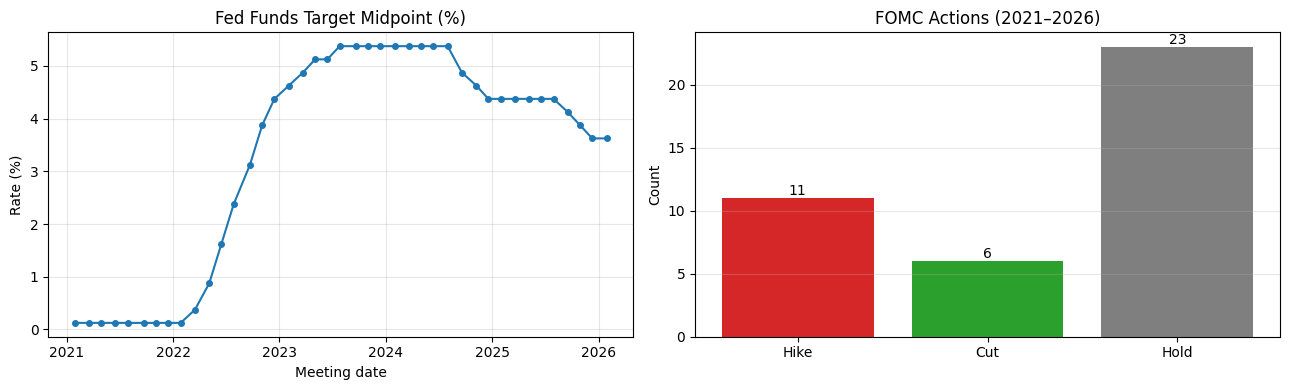

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Rate midpoint over time
ax = axes[0]
ax.plot(fomc["announcement_et"], fomc["midpoint"], marker="o", ms=4, lw=1.5)
ax.set_title("Fed Funds Target Midpoint (%)")
ax.set_xlabel("Meeting date")
ax.set_ylabel("Rate (%)")
ax.grid(True, alpha=0.3)

# Hike / cut / hold counts
ax = axes[1]
action_counts = {"Hike": fomc["is_hike"].sum(), "Cut": fomc["is_cut"].sum(), "Hold": fomc["is_hold"].sum()}
bars = ax.bar(action_counts.keys(), action_counts.values(), color=["#d62728", "#2ca02c", "#7f7f7f"])
ax.bar_label(bars)
ax.set_title("FOMC Actions (2021–2026)")
ax.set_ylabel("Count")
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

In [6]:
# Votes and dissents
print("Dissent count distribution:")
print(fomc["votes_against"].value_counts().sort_index())

print("\nRate changes (bps):")
print(fomc["rate_change"].dropna().describe())

Dissent count distribution:
votes_against
0    31
1     6
2     3
3     1
Name: count, dtype: int64

Rate changes (bps):
count    40.000000
mean      0.087500
std       0.291712
min      -0.500000
25%       0.000000
50%       0.000000
75%       0.250000
max       0.750000
Name: rate_change, dtype: float64


## 3. Policy Rates

In [7]:
policy = load_policy_rates(DATA_RAW)
write_parquet(policy.reset_index(), DATA_CLEAN / "policy_rates.parquet")
print(policy.tail())
print(f"\nShape: {policy.shape}")

INFO: Loading policy rates from /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-raw/bloomberg-exports/policy-rate-data
INFO: Policy rates: 1341 days, 2020-12-30 to 2026-02-18
INFO: Wrote 1341 rows → /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/policy_rates.parquet


            fed_rate  boc_rate  boe_rate  boj_rate  ecb_rate  fed_minus_ecb  \
date                                                                          
2026-02-12      3.64      2.25      3.75      0.75      2.15           1.49   
2026-02-13      3.64      2.25      3.75      0.75      2.15           1.49   
2026-02-16      3.64      2.25      3.75      0.75      2.15           1.49   
2026-02-17      3.64      2.25      3.75      0.75      2.15           1.49   
2026-02-18      3.64      2.25      3.75      0.75      2.15           1.49   

            fed_minus_boj  fed_minus_boe  fed_minus_boc  
date                                                     
2026-02-12           2.89          -0.11           1.39  
2026-02-13           2.89          -0.11           1.39  
2026-02-16           2.89          -0.11           1.39  
2026-02-17           2.89          -0.11           1.39  
2026-02-18           2.89          -0.11           1.39  

Shape: (1341, 9)


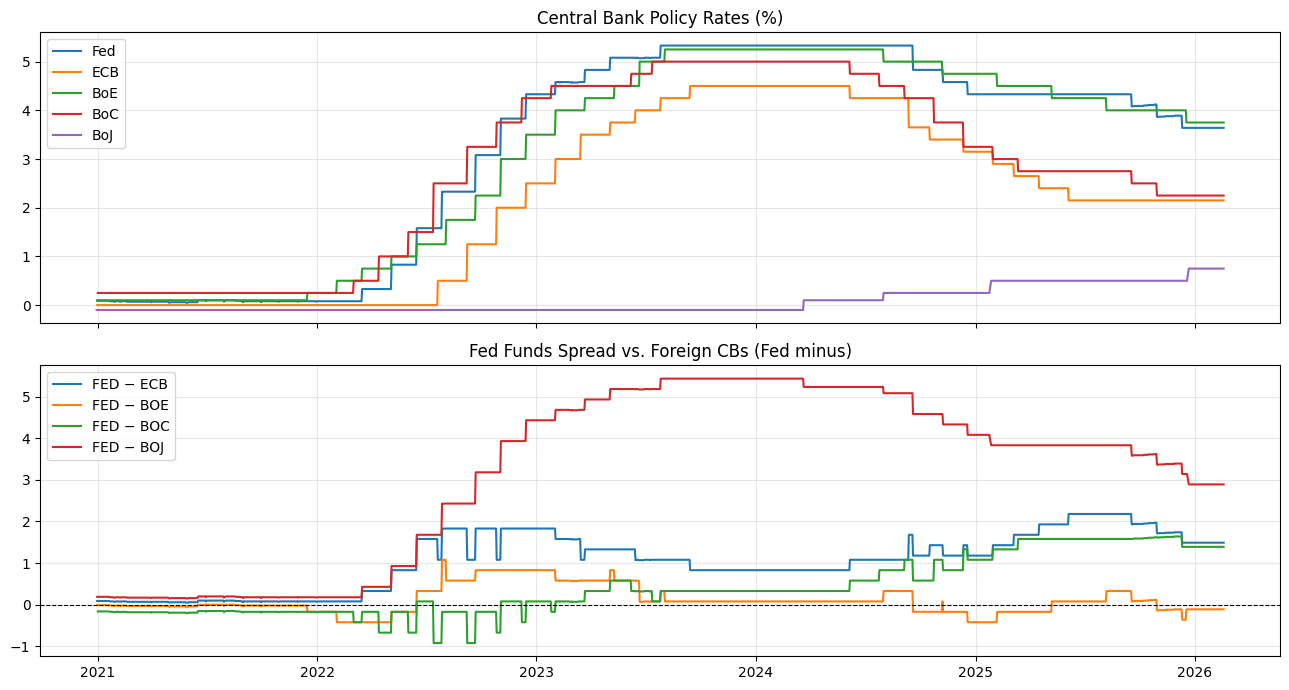

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(13, 7), sharex=True)

# Policy rates
rate_cols = ["fed_rate", "ecb_rate", "boe_rate", "boc_rate", "boj_rate"]
labels = {"fed_rate": "Fed", "ecb_rate": "ECB", "boe_rate": "BoE", "boc_rate": "BoC", "boj_rate": "BoJ"}
for col in rate_cols:
    axes[0].plot(policy.index, policy[col], label=labels[col], lw=1.5)
axes[0].set_title("Central Bank Policy Rates (%)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Spreads
spread_cols = ["fed_minus_ecb", "fed_minus_boe", "fed_minus_boc", "fed_minus_boj"]
for col in spread_cols:
    axes[1].plot(policy.index, policy[col], label=col.replace("fed_minus_", "Fed − ").upper(), lw=1.5)
axes[1].axhline(0, color="k", lw=0.8, ls="--")
axes[1].set_title("Fed Funds Spread vs. Foreign CBs (Fed minus)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Intraday Bars — Structure & Coverage

In [9]:
# Load ALL sources for all meetings — may take ~30 seconds
bars_raw = load_intraday_bars(DATA_RAW, meeting_ids)
print(f"Raw bars: {len(bars_raw):,} rows")
print(f"Sources: {bars_raw['source'].unique().tolist()}")
bars_raw.head()

INFO: Loaded 77025 bars across 8 sources × 41 meetings


Raw bars: 77,025 rows
Sources: ['SPX', 'USDCAD', 'USDEUR', 'USDGBP', 'USDJPY', 'UST10Y', 'UST2Y', 'VIX']


,timestamp_et,source,meeting_id,open,high,low,close,tick_count
0,2021-01-27 09:30:00-05:00,SPX,20210127,3836.83,3836.83,3791.80,3794.47,300.0
1,2021-01-27 09:35:00-05:00,SPX,20210127,3794.15,3794.15,3784.95,3791.32,300.0
2,2021-01-27 09:40:00-05:00,SPX,20210127,3790.48,3790.48,3774.80,3775.42,300.0
3,2021-01-27 09:45:00-05:00,SPX,20210127,3774.89,3781.74,3770.66,3772.30,300.0
4,2021-01-27 09:50:00-05:00,SPX,20210127,3772.21,3776.18,3767.10,3775.46,300.0


In [10]:
bars_clean, qa_report = qa_intraday_bars(bars_raw)

print("QA Report:")
for k, v in qa_report.items():
    if k != "large_gap_details":
        print(f"  {k}: {v}")

if qa_report["large_gap_details"]:
    print("\nLarge gaps (>10 min):")
    for g in qa_report["large_gap_details"]:
        print(f"  {g}")

INFO: QA: 77025 raw → 77025 clean  (dropped 0 no-close, 0 zero-tick, 0 dupes)


QA Report:
  n_raw: 77025
  n_dropped_no_close: 0
  n_dropped_zero_tick: 0
  n_dropped_duplicates: 0
  n_clean: 77025
  n_large_gaps: 29

Large gaps (>10 min):
  {'source': 'VIX', 'meeting_id': '20210127', 'max_gap_min': 20.0}
  {'source': 'VIX', 'meeting_id': '20210317', 'max_gap_min': 20.0}
  {'source': 'VIX', 'meeting_id': '20210428', 'max_gap_min': 20.0}
  {'source': 'VIX', 'meeting_id': '20210616', 'max_gap_min': 20.0}
  {'source': 'VIX', 'meeting_id': '20210728', 'max_gap_min': 20.0}
  {'source': 'VIX', 'meeting_id': '20210922', 'max_gap_min': 20.0}
  {'source': 'VIX', 'meeting_id': '20211103', 'max_gap_min': 15.0}
  {'source': 'VIX', 'meeting_id': '20211215', 'max_gap_min': 15.0}
  {'source': 'VIX', 'meeting_id': '20220126', 'max_gap_min': 15.0}
  {'source': 'VIX', 'meeting_id': '20220316', 'max_gap_min': 15.0}
  {'source': 'VIX', 'meeting_id': '20220504', 'max_gap_min': 15.0}
  {'source': 'VIX', 'meeting_id': '20220615', 'max_gap_min': 20.0}
  {'source': 'VIX', 'meeting_id': '2

In [11]:
# Save clean bars
write_parquet(bars_clean, DATA_CLEAN / "intraday_bars.parquet")

INFO: Wrote 77025 rows → /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/intraday_bars.parquet


In [12]:
# Bar counts per source
source_summary = (
    bars_clean.groupby("source")
    .agg(n_bars=("close", "count"), n_meetings=("meeting_id", "nunique"))
    .reset_index()
    .assign(avg_bars_per_meeting=lambda d: (d["n_bars"] / d["n_meetings"]).round(1))
)
print(source_summary.to_string(index=False))

source  n_bars  n_meetings  avg_bars_per_meeting
   SPX    3341          41                  81.5
USDCAD   11808          41                 288.0
USDEUR   11808          41                 288.0
USDGBP   11808          41                 288.0
USDJPY   11808          41                 288.0
UST10Y   10189          41                 248.5
 UST2Y    9933          40                 248.3
   VIX    6330          41                 154.4


## 5. Sample Bars Around the Announcement Window

In [13]:
# Pick a meeting (first one with full data) and plot USDEUR close around 14:00
sample_mid = meeting_ids[0]  # 20210127
sample_pair = "USDEUR"

import pytz
from datetime import datetime

ET = pytz.timezone("America/New_York")

sample = bars_clean[
    (bars_clean["source"] == sample_pair)
    & (bars_clean["meeting_id"] == sample_mid)
].copy()
sample = sample.sort_values("timestamp_et")

# Keep only announcement day (the second calendar day in the file)
ann_date = fomc.loc[fomc["meeting_id"] == sample_mid, "announcement_et"].iloc[0].date()
sample = sample[sample["timestamp_et"].dt.date == ann_date]

print(f"Meeting {sample_mid} | {sample_pair} | {len(sample)} bars on {ann_date}")
sample[["timestamp_et", "open", "high", "low", "close"]].head(10)

Meeting 20210127 | USDEUR | 204 bars on 2021-01-27


,timestamp_et,open,high,low,close
15233,2021-01-27 00:00:00-05:00,0.8226,0.8226,0.8225,0.8226
15234,2021-01-27 00:05:00-05:00,0.8226,0.8226,0.8225,0.8226
15235,2021-01-27 00:10:00-05:00,0.8226,0.8226,0.8225,0.8226
15236,2021-01-27 00:15:00-05:00,0.8226,0.8226,0.8225,0.8226
15237,2021-01-27 00:20:00-05:00,0.8226,0.8226,0.8225,0.8226
15238,2021-01-27 00:25:00-05:00,0.8226,0.8226,0.8226,0.8226
15239,2021-01-27 00:30:00-05:00,0.8226,0.8226,0.8225,0.8225
15240,2021-01-27 00:35:00-05:00,0.8225,0.8225,0.8223,0.8223
15241,2021-01-27 00:40:00-05:00,0.8223,0.8223,0.8222,0.8222
15242,2021-01-27 00:45:00-05:00,0.8222,0.8223,0.8222,0.8223


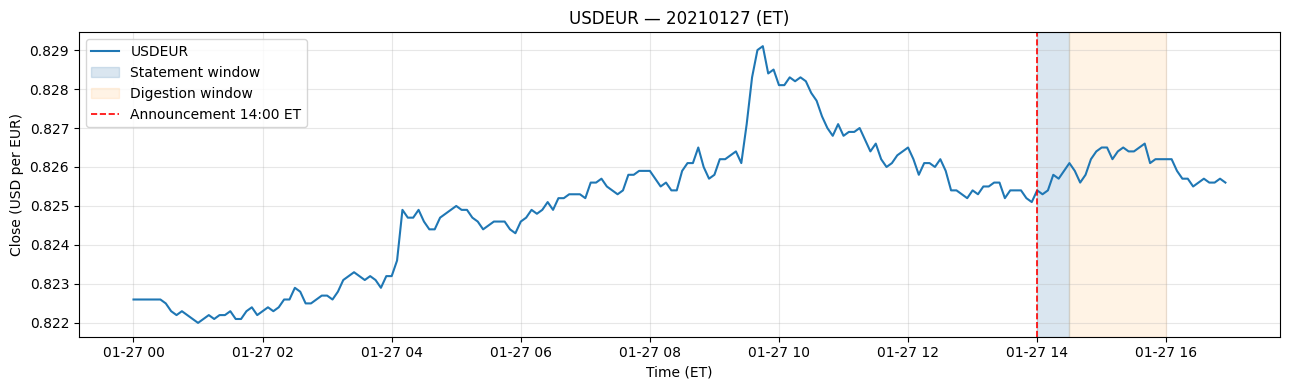

In [14]:
fig, ax = plt.subplots(figsize=(13, 4))
ax.plot(sample["timestamp_et"], sample["close"], lw=1.5, label=sample_pair)

# Shade the two prediction windows
ann_et = fomc.loc[fomc["meeting_id"] == sample_mid, "announcement_et"].iloc[0]
stmt_start = ET.localize(datetime.combine(ann_date, datetime.strptime("14:00", "%H:%M").time()))
stmt_end   = ET.localize(datetime.combine(ann_date, datetime.strptime("14:30", "%H:%M").time()))
dig_end    = ET.localize(datetime.combine(ann_date, datetime.strptime("16:00", "%H:%M").time()))

ax.axvspan(stmt_start, stmt_end, alpha=0.2, color="steelblue",  label="Statement window")
ax.axvspan(stmt_end,   dig_end,  alpha=0.1, color="darkorange", label="Digestion window")
ax.axvline(ann_et, color="red", lw=1.2, ls="--", label=f"Announcement {ann_et.strftime('%H:%M')} ET")

ax.set_title(f"{sample_pair} — {sample_mid} (ET)")
ax.set_xlabel("Time (ET)")
ax.set_ylabel("Close (USD per EUR)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Coverage Heatmap

In [15]:
cov = coverage_report(bars_clean, fomc)

# Separate source columns from the date column
source_cols = [c for c in cov.columns if c != "announcement_et"]
cov_matrix = cov[source_cols].copy()

print(f"Coverage table ({len(cov)} meetings × {len(source_cols)} sources)")
print("Expected bars per meeting ≈ 288 (FX/treasury, 24h), 78 (SPX/VIX, ~6.5h)")
cov_matrix.describe().round(0)

Coverage table (41 meetings × 8 sources)
Expected bars per meeting ≈ 288 (FX/treasury, 24h), 78 (SPX/VIX, ~6.5h)


,SPX,USDCAD,USDEUR,USDGBP,USDJPY,UST10Y,UST2Y,VIX
count,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0
mean,81.0,288.0,288.0,288.0,288.0,249.0,242.0,154.0
std,1.0,0.0,0.0,0.0,0.0,25.0,46.0,1.0
min,81.0,288.0,288.0,288.0,288.0,168.0,0.0,153.0
25%,81.0,288.0,288.0,288.0,288.0,253.0,252.0,154.0
50%,81.0,288.0,288.0,288.0,288.0,253.0,253.0,154.0
75%,82.0,288.0,288.0,288.0,288.0,264.0,264.0,156.0
max,82.0,288.0,288.0,288.0,288.0,265.0,265.0,156.0


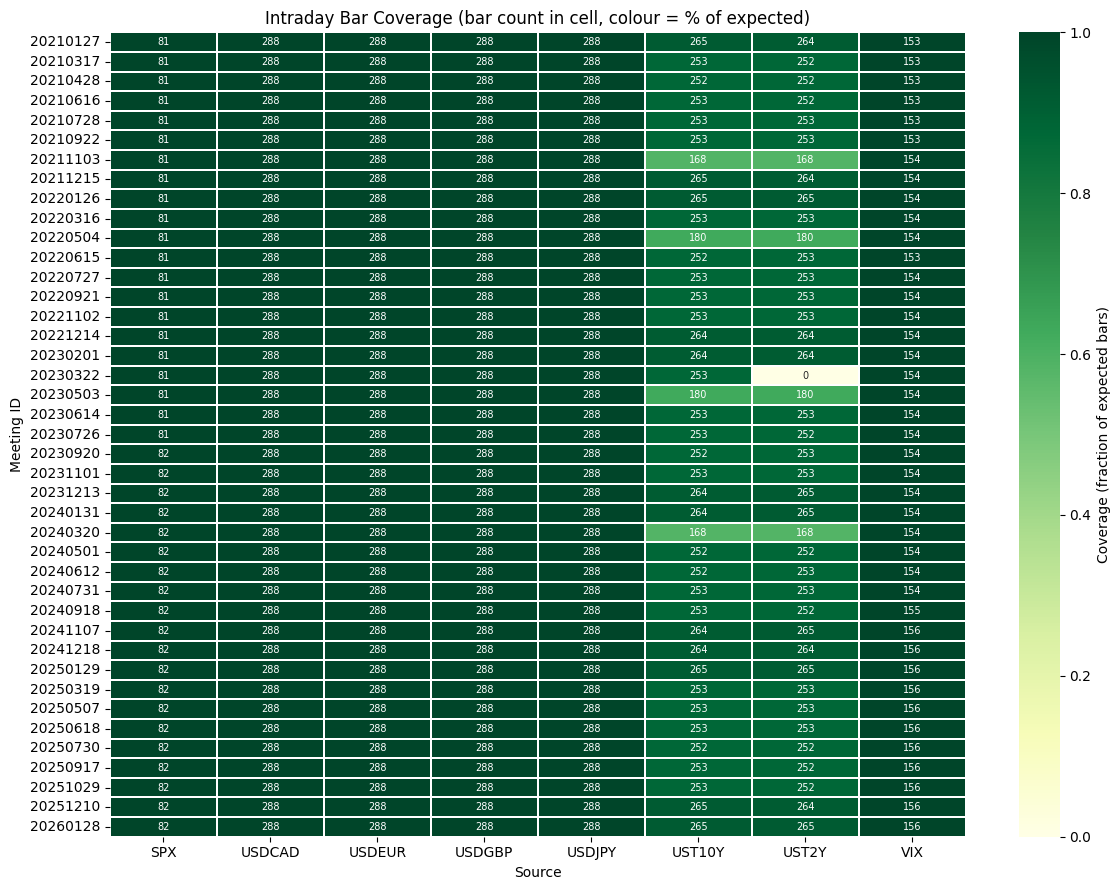

In [16]:
# Normalise by expected bars per source for the heatmap
expected = {s: 288 if s not in ("SPX", "VIX") else 78 for s in source_cols}
cov_pct = cov_matrix.copy()
for s in source_cols:
    cov_pct[s] = (cov_matrix[s] / expected[s]).clip(0, 1)

fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(
    cov_pct,
    ax=ax,
    cmap="YlGn",
    vmin=0, vmax=1,
    linewidths=0.3,
    annot=cov_matrix,
    fmt="d",
    annot_kws={"size": 7},
    cbar_kws={"label": "Coverage (fraction of expected bars)"},
)
ax.set_title("Intraday Bar Coverage (bar count in cell, colour = % of expected)")
ax.set_xlabel("Source")
ax.set_ylabel("Meeting ID")
plt.tight_layout()
plt.show()

In [17]:
# Meetings with any source below 50% coverage
low_cov = cov_pct[cov_pct.min(axis=1) < 0.5]
if low_cov.empty:
    print("✓ No meetings with <50% coverage in any source")
else:
    print(f"Meetings with low coverage ({len(low_cov)}):")
    print(low_cov)

Meetings with low coverage (1):
            SPX  USDCAD  USDEUR  USDGBP  USDJPY    UST10Y  UST2Y  VIX
meeting_id                                                           
20230322    1.0     1.0     1.0     1.0     1.0  0.878472    0.0  1.0


## 7. Transcript Availability

In [18]:
import os

stmt_dir  = DATA_RAW / "fomc-transcripts" / "statements"
pc_dir    = DATA_RAW / "fomc-transcripts" / "press_conf"

stmt_ids = {f.stem.replace("monetary", "").replace("a1", "") for f in stmt_dir.glob("monetary*.pdf")}
pc_ids   = {f.stem.replace("FOMCpresconf", "") for f in pc_dir.glob("FOMCpresconf*.pdf")}

print(f"Statement PDFs  : {len(stmt_ids)} (expected 41)")
print(f"Press conf PDFs : {len(pc_ids)} (expected 41)")

missing_stmt = set(meeting_ids) - stmt_ids
missing_pc   = set(meeting_ids) - pc_ids

if missing_stmt: print(f"Missing statements  : {sorted(missing_stmt)}")
else:            print("✓ All statement PDFs present")

if missing_pc:   print(f"Missing press confs : {sorted(missing_pc)}")
else:            print("✓ All press conf PDFs present")

Statement PDFs  : 41 (expected 41)
Press conf PDFs : 40 (expected 41)
✓ All statement PDFs present
Missing press confs : ['20240731']


In [19]:
# Extract transcripts and save to JSON (slow: ~60s for 82 PDFs)
# Skip if already saved
transcript_json = DATA_CLEAN / "transcripts.json"
if not transcript_json.exists():
    print("Extracting transcripts (this takes ~60 seconds) ...")
    transcripts = load_transcripts(DATA_RAW, meeting_ids)
    save_transcripts_json(transcripts, transcript_json)
else:
    print(f"Transcripts already saved at {transcript_json}")
    from src.ingest import load_transcripts_json
    transcripts = load_transcripts_json(transcript_json)

Transcripts already saved at /Users/jackgordon/Library/CloudStorage/OneDrive-Personal/04 Chicago Booth/01 Classes/35137 - ML in Finance/35137-ML-finance/final-project/data-clean/transcripts.json


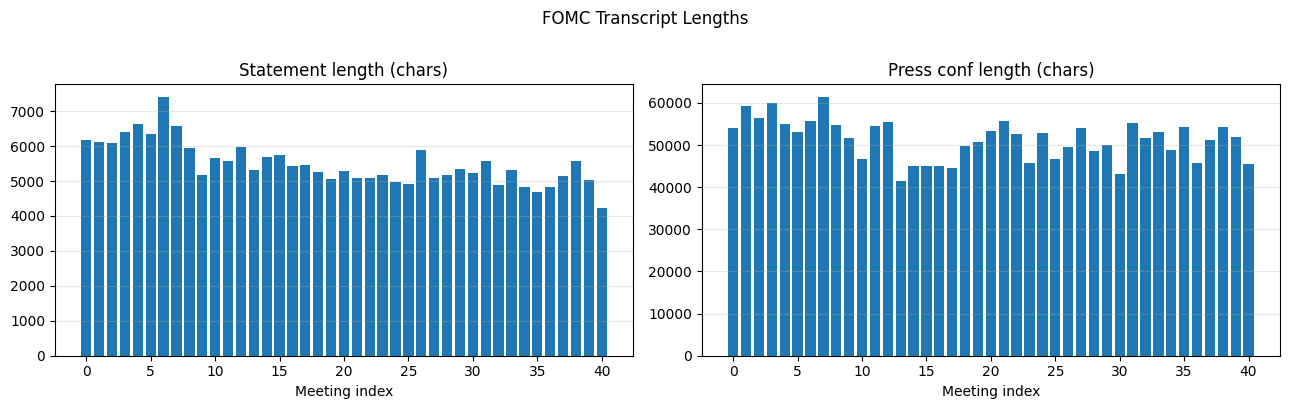


Summary:
       stmt_chars  pc_chars
count          41        41
mean         5495     51282
std           618      4759
min          4238     41493
25%          5095     46642
50%          5319     51795
75%          5889     54448
max          7398     61330


In [20]:
# Check lengths — longer transcripts = more content for text features
lengths = {
    mid: {
        "stmt_chars": len(transcripts[mid]["statement"]),
        "pc_chars":   len(transcripts[mid]["press_conf"]),
    }
    for mid in meeting_ids
    if mid in transcripts
}
len_df = pd.DataFrame(lengths).T

fig, axes = plt.subplots(1, 2, figsize=(13, 4))
for ax, col, title in zip(
    axes,
    ["stmt_chars", "pc_chars"],
    ["Statement length (chars)", "Press conf length (chars)"],
):
    ax.bar(range(len(len_df)), len_df[col], width=0.8)
    ax.set_title(title)
    ax.set_xlabel("Meeting index")
    ax.grid(True, alpha=0.3, axis="y")

plt.suptitle("FOMC Transcript Lengths", y=1.01)
plt.tight_layout()
plt.show()

print("\nSummary:")
print(len_df.describe().round(0).astype(int))

In [21]:
# Peek at one statement
sample_stmt = transcripts[meeting_ids[0]]["statement"]
print(f"--- Statement {meeting_ids[0]} (first 500 chars) ---")
print(sample_stmt[:500])

--- Statement 20210127 (first 500 chars) ---
For release at 2 p.m. EST January 27, 2021
The Federal Reserve is committed to using its full range of tools to support the
U.S. economy in this challenging time, thereby promoting its maximum employment and
price stability goals.
The COVID-19 pandemic is causing tremendous human and economic hardship
across the United States and around the world. The pace of the recovery in economic
activity and employment has moderated in recent months, with weakness concentrated in
the sectors most adversely 


## Summary

| Check | Result |
|---|---|
| FOMC meetings loaded | 41 |
| Clean bar rows | see QA report above |
| Sources with full coverage | see heatmap above |
| Statement PDFs | 41 |
| Press conf PDFs | 41 |

**Next:** `02_eda_targets.ipynb` — compute log-returns for each meeting × pair × window.